# NLP-Solution
Zadanie:
* Przygotuj wstępną eksplorację danych (np. długości tekstów, najczęstsze słowa .itp)
* Jak automatycznie znalazłbyś teksty z podobnych tematów?
* Stwórz model klasyfikujący. Jakie dobre i słabe strony ma otrzymany model? Jak je można wyelminować albo zminimalizować?

## Import libraries

In [1]:
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import tensorflow as tf
from sklearnex import patch_sklearn

from numpy import ndarray
from cupy._core.core import ndarray as cdarray
from pandas import DataFrame, Series
from spacy.lang.pl import Polish
from spacy.tokens.doc import Doc
from scipy.stats import pearsonr
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPool1D, Dense, Dropout
from tensorflow.keras import Model
from tensorflow import concat
from typing import List, Dict, Tuple

sns.set_theme()
spacy.require_gpu()
patch_sklearn()

tf.config.list_physical_devices('GPU')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load dataset

In [2]:
path: str = \
    'polish_sentiment_dataset.csv'

dataset: DataFrame = \
    pd.read_csv(path)
    
print(f'rows: {dataset.shape[0]}, columns: {dataset.shape[1]}')
dataset.head()

rows: 936883, columns: 3


,description,length,rate
0,Polecam nie pierwszy i nie ostatni raz!,39.0,1.0
1,Bardzo dobra komunikacja sms i telefoniczna. Z...,121.0,1.0
2,Polecam zakupy w tym sklepie. Są dostępne częś...,87.0,1.0
3,0,0.0,0.0
4,Jestem w pełni zadowolona z przebiegu transakcji,48.0,1.0


## Data exploration

### Checking data types

In [3]:
dataset.dtypes

description     object
length         float64
rate           float64
dtype: object

### Checking `NaNs`

In [4]:
dataset.apply(lambda row: sum(pd.isna(row)))

description       629
length         174047
rate               66
dtype: int64

### Checking empty strings

In [5]:
(dataset.description == u'').sum()

0

### Checking number of classes from `rate` column

In [6]:
dataset.groupby('rate').size()

rate
-1.0    184020
 0.0     18547
 1.0    734250
dtype: int64

### Checking ratio of classes from `rate` column

In [7]:
round(dataset.groupby('rate').size() / dataset.shape[0] * 100, 2)

rate
-1.0    19.64
 0.0     1.98
 1.0    78.37
dtype: float64

### Getting closer look of `0` `rate` column

In [8]:
dataset[dataset.rate == 0].head(10)

,description,length,rate
3,0,0.0,0.0
16,0,0.0,0.0
34,0,0.0,0.0
76,0,0.0,0.0
131,0,0.0,0.0
172,0,0.0,0.0
230,0,0.0,0.0
274,0,0.0,0.0
288,0,0.0,0.0
345,0,0.0,0.0


### Checking if `0` `rate` column contains any valuable informations
* we assume that valuable informations have `description` values other than `0`
* we assume that valuable informations have `length` values other than `0`

In [9]:
f'valuable informations: \
    {len(dataset[(dataset.rate == 0) & (dataset.description != "0")])}'

'valuable informations:     0'

In [10]:
f'valuable informations: \
    {len(dataset[(dataset.rate == 0) & (dataset.length != 0)])}'

'valuable informations:     0'

## Data preparation


### Drop `length` column

In [11]:
clean_dataset: DataFrame = \
    dataset.drop(columns = ['length'])
    
clean_dataset.head()

,description,rate
0,Polecam nie pierwszy i nie ostatni raz!,1.0
1,Bardzo dobra komunikacja sms i telefoniczna. Z...,1.0
2,Polecam zakupy w tym sklepie. Są dostępne częś...,1.0
3,0,0.0
4,Jestem w pełni zadowolona z przebiegu transakcji,1.0


### Change `description` column to string


In [12]:
clean_dataset.description = \
    clean_dataset.description.astype('string')

clean_dataset.dtypes

description     string
rate           float64
dtype: object

### Drop `NaNs`


In [13]:
clean_dataset = \
    clean_dataset[clean_dataset.description.notna()]

clean_dataset = \
    clean_dataset[clean_dataset.rate.notna()]

clean_dataset.apply(lambda row: sum(pd.isna(row)))

description    0
rate           0
dtype: int64

### Drop `0` class from `rate` column


In [14]:
clean_dataset = \
    clean_dataset[clean_dataset.rate != 0]

f'number of 0 rates: {(clean_dataset.rate == 0).sum()}'

'number of 0 rates: 0'

### Convert `-1` class to `0` class from `rate` column

In [15]:
clean_dataset.rate.replace(-1, 0, inplace = True)

round(clean_dataset.groupby('rate').size() / clean_dataset.shape[0] * 100, 2)

rate
0.0    19.99
1.0    80.01
dtype: float64

In [16]:
clean_dataset.groupby('rate').size()

rate
0.0    183391
1.0    734250
dtype: int64

### Change column names

In [17]:
columns_to_rename: Dict[str, str] = \
    {'description': 'Sentence', 'rate': 'Rate'}

clean_dataset = \
    clean_dataset.rename(columns = columns_to_rename)

print(f'clean_dataset rows: {clean_dataset.shape[0]}, columns: {clean_dataset.shape[1]}')
clean_dataset.head()

clean_dataset rows: 917641, columns: 2


,Sentence,Rate
0,Polecam nie pierwszy i nie ostatni raz!,1.0
1,Bardzo dobra komunikacja sms i telefoniczna. Z...,1.0
2,Polecam zakupy w tym sklepie. Są dostępne częś...,1.0
4,Jestem w pełni zadowolona z przebiegu transakcji,1.0
5,Transakcja przebiegła błyskawicznie. Pełen pro...,1.0


## Reduce dataset
reduce dataset because of gpu and memory capability of my laptop

### Sort dataset to equal size for both classes

In [18]:
reduced_dataset: DataFrame = \
    clean_dataset.copy().sort_values('Rate')

print(f'clean_dataset rows: {reduced_dataset.shape[0]}, columns: {reduced_dataset.shape[1]}')
reduced_dataset.head()

clean_dataset rows: 917641, columns: 2


,Sentence,Rate
936882,wiesz człowieku że on ją nawet nie uderzył i m...,0.0
814850,jak mój kot to zobaczył to od razu spierdolił ...,0.0
814849,a byłaś u spowiedzi niegrzeczna dziewczynko,0.0
814848,mmmLala bierz mnie,0.0
814847,Tak chujowe że aż mi chromosom wyjebało Sorry ...,0.0


### Concatenate `DataFrames` with class `0` and `1` to one `DataFrame` 

In [19]:
negative: DataFrame = \
    reduced_dataset[:10_000]
    
positive: DataFrame = \
    reduced_dataset[-10_000:]
    
reduced_dataset = \
    pd.concat([negative, positive], ignore_index = True, sort = False)
    
print(f'clean_dataset rows: {reduced_dataset.shape[0]}, columns: {reduced_dataset.shape[1]}')
round(reduced_dataset.groupby('Rate').size() / reduced_dataset.shape[0] * 100, 2)

clean_dataset rows: 20000, columns: 2


Rate
0.0    50.0
1.0    50.0
dtype: float64

## Data Analysis

### Load polish words corpus

In [20]:
nlp: Polish = \
    spacy.load('pl_core_news_lg')

f'default batch size: {nlp.batch_size}'

'default batch size: 256'

### Tokenize words

In [21]:
documents: List[Doc] = \
    list(nlp.pipe(reduced_dataset.Sentence, disable = "ner", n_process = 1, batch_size = 128))

### Create dataframe for analysis

In [22]:
analyzed_dataset: DataFrame = \
    reduced_dataset.copy()

print(f'clean_dataset rows: {analyzed_dataset.shape[0]}, columns: {analyzed_dataset.shape[1]}')
analyzed_dataset.head()

clean_dataset rows: 20000, columns: 2


,Sentence,Rate
0,wiesz człowieku że on ją nawet nie uderzył i m...,0.0
1,jak mój kot to zobaczył to od razu spierdolił ...,0.0
2,a byłaś u spowiedzi niegrzeczna dziewczynko,0.0
3,mmmLala bierz mnie,0.0
4,Tak chujowe że aż mi chromosom wyjebało Sorry ...,0.0


### Count of occurences part of speeches, words and characters
| polish | index | shortcut | name | examples |
| --- | --- | --- | --- | --- |
| przymiotnik | 84 | ADJ | adjective | big, old, green, incomprehensible, first |
| przyimek | 85 | ADP |	adposition | in, to, during |
| przysłówek | 86 | ADV | adverb | very, tomorrow, down, where, there |
| czasownik posiłkowy | 87 | AUX |	auxiliary | is, has (done), will (do), should (do) |
| spójnik | 88 | CONJ | conjunction | and, or, but |
| spójnik współrzędny | 89 | CCONJ | coordinating conjunction | and, or, but |
| określnik | 90 | DET | determiner | a, an, the |
| wykrzyknik | 91 | INTJ | interjection | psst, ouch |
| rzeczownik | 92 | NOUN | noun | girl, cat, tree, air, beauty |
| liczebnik | 93 | NUM | numeral | 1, 2017, one, seventy-seven, IV, MMXIV |
| partykuła | 94 | PART | particle | ’s, not |
| zaimek | 95 | PRON | pronoun | I, you, he, she, myself, themselves, somebody |
| nazwy własne | 96 | PROPN | proper noun | Mary, John, London, NATO, HBO |
| interpunkcja | 97 | PUNCT | punctuation | ., (, ), ? |
| spójnik podrzędny | 98 | subordinating conjunction | subordinating conjunction | if, while, that |
| symbol | 99 | SYM | symbol | $, %, §, ©, +, −, ×, ÷, =, :), 😝 |
| czasownik | 100 | VERB | verb | run, runs, running, eat, ate, eating |
| inne | 102 | X | other | dasdsadsa |
| spacja | 104 | SPACE | space | |

In [23]:
analyzed_dataset['NoCount'] = \
    [len([word for word in document if word.norm == nlp.vocab['nie'].norm]) for document in documents]

analyzed_dataset['WordsCount'] = \
    [len(document) for document in documents]

analyzed_dataset['CharactersCount'] = \
    [len(sentence) for sentence in analyzed_dataset.Sentence]

analyzed_dataset['StopWordsCount'] = \
    [len([word for word in document if word.is_stop]) for document in documents]

analyzed_dataset['AdjectivesCount'] = \
    [len([word for word in document if word.pos == 84]) for document in documents]

analyzed_dataset['AdverbsCount'] = \
    [len([word for word in document if word.pos == 86]) for document in documents]

analyzed_dataset['ConjunctionsCount'] = \
    [len([word for word in document if word.pos == 88]) for document in documents]

analyzed_dataset['NounsCount'] = \
    [len([word for word in document if word.pos == 92]) for document in documents]

analyzed_dataset['NumeralsCount'] = \
    [len([word for word in document if word.pos == 93]) for document in documents]

analyzed_dataset['ParticlesCount'] = \
    [len([word for word in document if word.pos == 94]) for document in documents]

analyzed_dataset['PunctuationCount'] = \
    [len([word for word in document if word.pos == 97]) for document in documents]

analyzed_dataset['SubordinatingConjunctionsCount'] = \
    [len([word for word in document if word.pos == 98]) for document in documents]

analyzed_dataset['SymbolsCount'] = \
    [len([word for word in document if word.pos == 99]) for document in documents]

analyzed_dataset['VerbsCount'] = \
    [len([word for word in document if word.pos == 100]) for document in documents]

print(analyzed_dataset.dtypes)
analyzed_dataset.head()

Sentence                           string
Rate                              float64
NoCount                             int64
WordsCount                          int64
CharactersCount                     int64
StopWordsCount                      int64
AdjectivesCount                     int64
AdverbsCount                        int64
ConjunctionsCount                   int64
NounsCount                          int64
NumeralsCount                       int64
ParticlesCount                      int64
PunctuationCount                    int64
SubordinatingConjunctionsCount      int64
SymbolsCount                        int64
VerbsCount                          int64
dtype: object


,Sentence,Rate,NoCount,WordsCount,CharactersCount,StopWordsCount,AdjectivesCount,AdverbsCount,ConjunctionsCount,NounsCount,NumeralsCount,ParticlesCount,PunctuationCount,SubordinatingConjunctionsCount,SymbolsCount,VerbsCount
0,wiesz człowieku że on ją nawet nie uderzył i m...,0.0,1,13,62,8,0,0,0,1,0,2,0,1,0,3
1,jak mój kot to zobaczył to od razu spierdolił ...,0.0,0,12,60,7,0,0,0,2,0,0,0,2,0,3
2,a byłaś u spowiedzi niegrzeczna dziewczynko,0.0,0,7,45,2,1,0,0,2,0,0,0,0,0,1
3,mmmLala bierz mnie,0.0,0,3,19,1,0,1,0,0,0,0,0,0,0,1
4,Tak chujowe że aż mi chromosom wyjebało Sorry ...,0.0,0,15,90,8,2,3,0,1,0,2,0,2,0,1


### Describe data

In [26]:
analyzed_dataset.drop(columns = ['Sentence', 'Rate']).describe()

,NoCount,WordsCount,CharactersCount,StopWordsCount,AdjectivesCount,AdverbsCount,ConjunctionsCount,NounsCount,NumeralsCount,ParticlesCount,PunctuationCount,SubordinatingConjunctionsCount,SymbolsCount,VerbsCount
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.171650,11.883500,67.169300,3.772200,1.363050,0.892750,0.0,2.642350,0.074650,0.442650,1.500400,0.235800,0.051350,1.309450
std,0.511468,20.880829,85.570797,4.848596,1.678596,1.220501,0.0,3.059167,0.325703,0.923338,8.566964,0.611733,0.250233,1.874211
min,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,35.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,9.000000,49.000000,3.000000,1.000000,1.000000,0.0,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,13.000000,76.000000,5.000000,2.000000,1.000000,0.0,3.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000
max,30.000000,2360.000000,7140.000000,243.000000,48.000000,20.000000,0.0,98.000000,8.000000,46.000000,1168.000000,31.000000,5.000000,83.000000


### Plot sum of occurences

<AxesSubplot:title={'center':'Sum of occurences'}, xlabel='Names'>

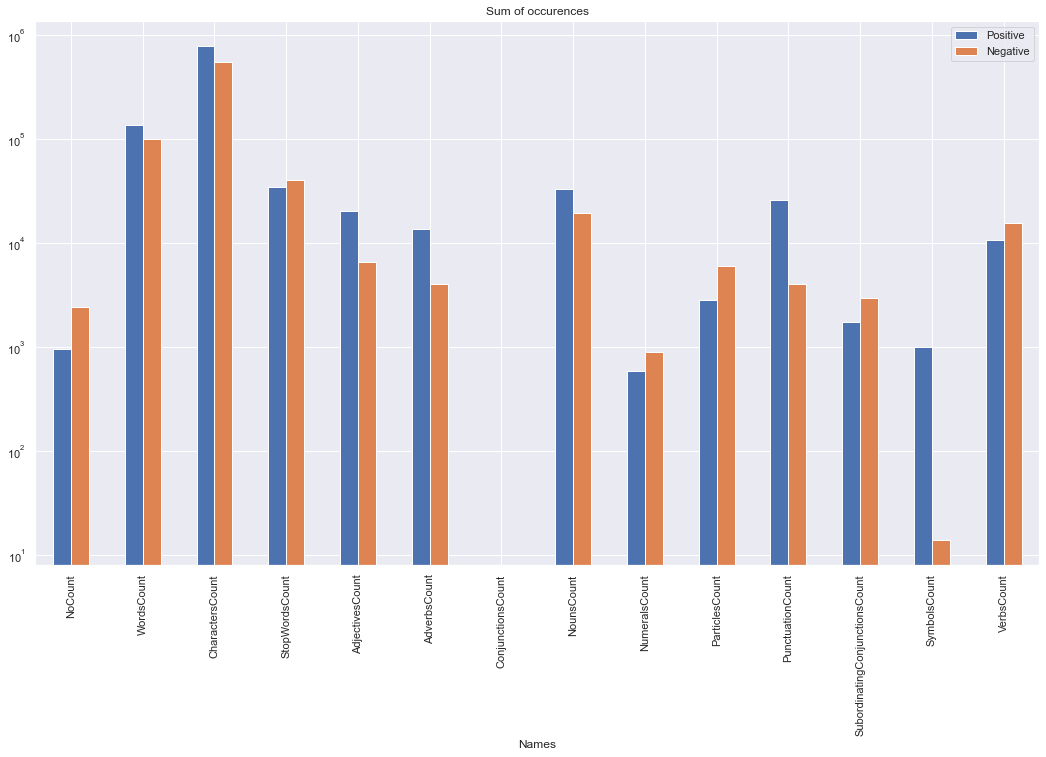

In [27]:
sum_occurences: DataFrame = \
    analyzed_dataset.drop(columns = ['Sentence']).groupby(['Rate']).sum().transpose()

sum_occurences['Names'] = \
    sum_occurences.index

sum_occurences.columns = \
    ['Negative', 'Positive', 'Names']
    
sum_occurences.plot(x = 'Names', y = ['Positive', 'Negative'], logy = True, kind = "bar", title = 'Sum of occurences', figsize = (18, 10))

### Plot mean of occurences

<AxesSubplot:title={'center':'Mean of occurences'}, xlabel='Names'>

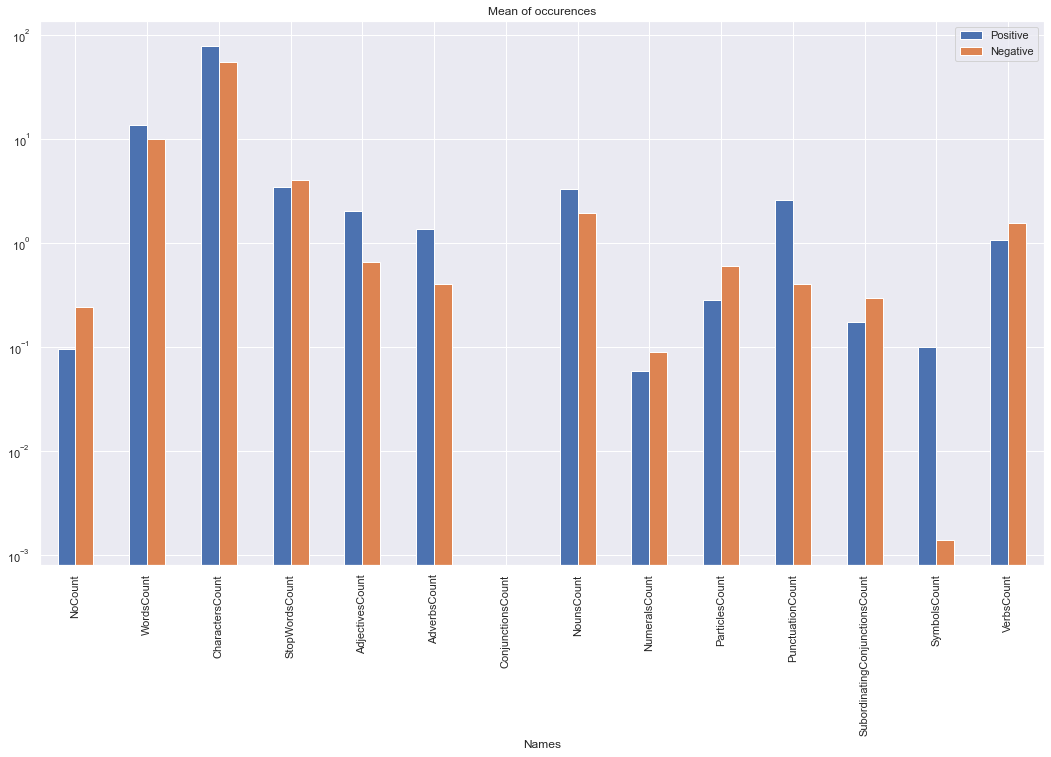

In [28]:
mean_occurences: DataFrame = \
    analyzed_dataset.drop(columns = ['Sentence']).groupby(['Rate']).mean().transpose()

mean_occurences['Names'] = \
    mean_occurences.index

mean_occurences.columns = \
    ['Negative', 'Positive', 'Names']
    
mean_occurences.plot(x = 'Names', y = ['Positive', 'Negative'], logy = True, kind = "bar", title = 'Mean of occurences', figsize = (18, 10))

### Plot correlations

C:\Users\mikol\miniconda3\envs\nlp\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

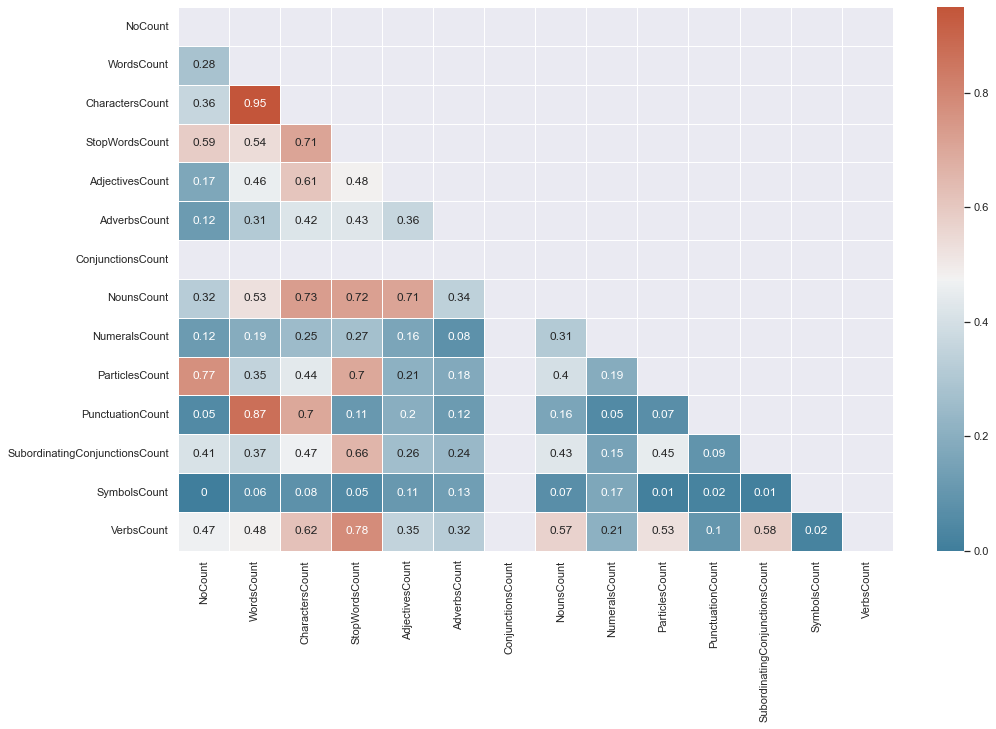

In [29]:
correlations: DataFrame = \
    analyzed_dataset.drop(columns = ['Sentence', 'Rate'])

correlation_matrix: DataFrame = \
    DataFrame(data = [], index = correlations.columns, columns = correlations.columns).astype(float)

for i in correlations.columns:
    for j in correlations.columns:
        correlation_matrix.loc[i, j] = \
            np.round(pearsonr(correlations.loc[:, i], correlations.loc[:, j])[0], 2)

_, axes = plt.subplots(figsize = (16, 10))

mask: ndarray = \
    np.triu(np.ones_like(correlation_matrix, dtype = bool))

cmap: LinearSegmentedColormap = \
    sns.diverging_palette(230, 20, as_cmap = True)

sns.heatmap(correlation_matrix.values,
    xticklabels = correlation_matrix.columns,
    yticklabels = correlation_matrix.columns,
    mask = mask,
    annot = True,
    linewidths = .5,
    ax = axes,
    cmap = cmap,
    fmt = 'g')

### Plot reduced dimensions

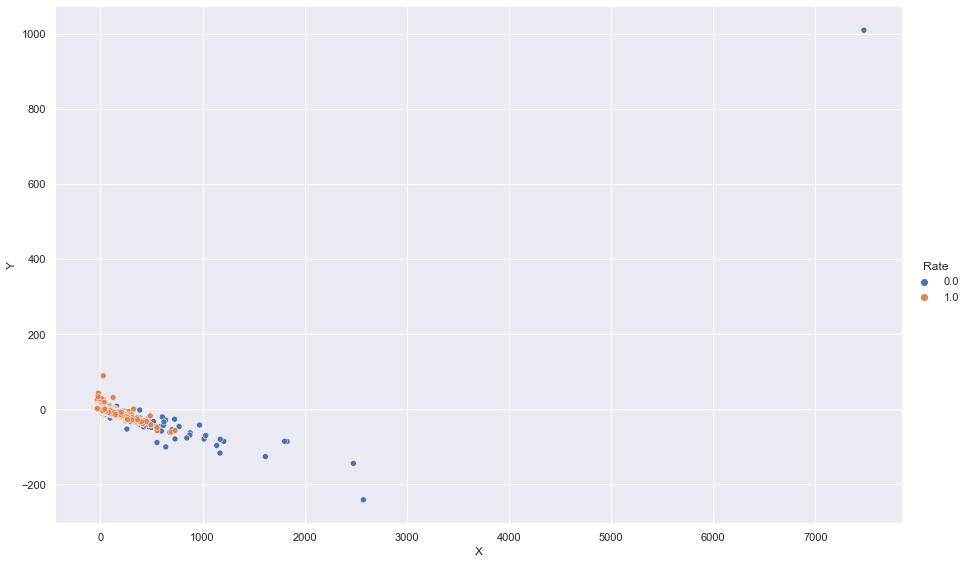

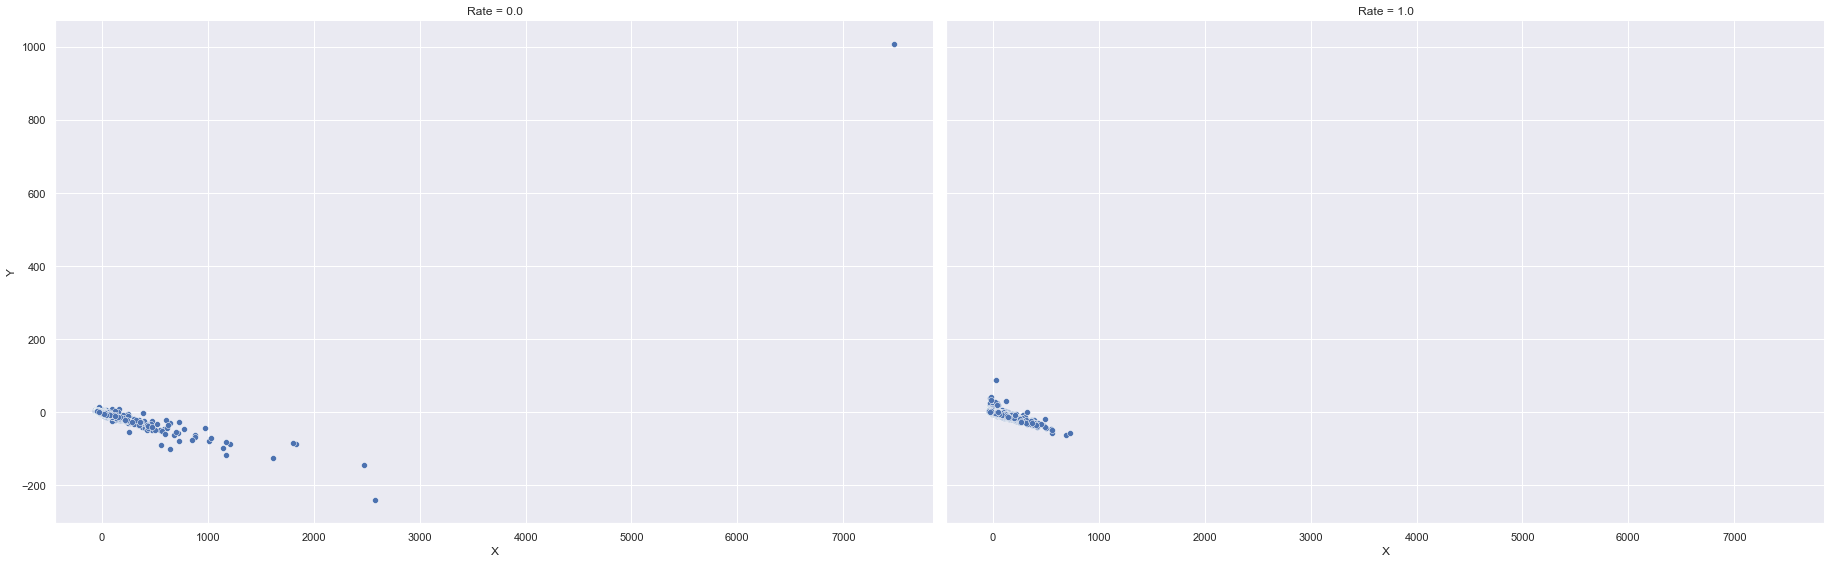

In [30]:
from sklearn.decomposition import PCA

pca: PCA = \
    PCA(n_components = 2)

compressed_occurences: DataFrame = \
    DataFrame(data = pca.fit_transform(correlations), columns = ['X', 'Y'])

compressed_occurences['Rate'] = \
    analyzed_dataset.Rate

sns.relplot(data = compressed_occurences, x = 'X', y = 'Y', hue = 'Rate', kind = 'scatter', aspect = 1.6, height = 8)
plt.show()
sns.relplot(data = compressed_occurences, x = 'X', y = 'Y', col = 'Rate', kind = 'scatter', aspect = 1.6, height = 8)

## Train model

### Create inputs

In [31]:
vector_sequences: cdarray = \
    cp.array([sentence.vector for sentence in documents])

vector_sequences.shape, vector_sequences.dtype

((20000, 300), dtype('float32'))

### Create labels

In [32]:
rates: cdarray = \
    cp.array(reduced_dataset.Rate, dtype = cp.int16)

rates.shape, rates.dtype

((20000,), dtype('int16'))

### Create train, test split

In [33]:
X_train: ndarray
X_test: ndarray
y_train: ndarray
y_test: ndarray

X_train, X_test, y_train, y_test = \
    train_test_split(vector_sequences.get(), rates.get(), test_size = 0.33, random_state = 2021)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, type(X_train), type(y_train)

((13400, 300), (6600, 300), (13400,), (6600,), numpy.ndarray, numpy.ndarray)

### Create model

In [34]:
class DCNN(Model):
    def __init__(self, vocabulary_size: int,
                 embedding_size: int, filters_number: int,
                 output_size: int, classes_number: int,
                 dropout_rate: float, name = 'dcnn'):

        super(DCNN, self).__init__(name = name)

        self.embedding = Embedding(vocabulary_size, embedding_size)
        
        self.bigram = Conv1D(filters = filters_number, kernel_size = 2, padding = 'valid', activation = lambda x : tf.nn.leaky_relu(x, alpha = 0.02))
        self.trigram = Conv1D(filters = filters_number, kernel_size = 3, padding = 'valid', activation = lambda x : tf.nn.leaky_relu(x, alpha = 0.02))
        self.fourgram = Conv1D(filters = filters_number, kernel_size = 4, padding = 'valid', activation = lambda x : tf.nn.leaky_relu(x, alpha = 0.02))
        self.fifthgram = Conv1D(filters = filters_number, kernel_size = 5, padding = 'valid', activation = lambda x : tf.nn.leaky_relu(x, alpha = 0.02))
        
        self.pool = GlobalMaxPool1D()

        self.dense_1 = Dense(units = output_size, activation = lambda x : tf.nn.leaky_relu(x, alpha = 0.01))
        self.dropout_1 = Dropout(rate = dropout_rate)
        
        if classes_number == 2:
            self.last_dense = Dense(units = 1, activation = 'sigmoid')
        else:
            self.last_dense = Dense(units = classes_number, activation = 'softmax')

    def call(self, inputs: ndarray, training: bool = True):
        embeddings = self.embedding(inputs)
        
        bigram = self.bigram(embeddings)
        bigram = self.pool(bigram)

        trigram = self.trigram(embeddings)
        trigram = self.pool(trigram)
        
        fourgram = self.fourgram(embeddings)
        fourgram = self.pool(fourgram)
        
        fifthgram = self.fifthgram(embeddings)
        fifthgram = self.pool(fifthgram)

        output = concat([bigram, trigram, fourgram, fifthgram], axis = -1)
        
        output = self.dense_1(output)
        output = self.dropout_1(output, training)
        
        output = self.last_dense(output)

        return output

### Set hyperparameters

In [35]:
VOCABULARY_SIZE: int = len(nlp.vocab)
EMBEDDING_SIZE: int = 300
FILTERS_NUMBER: int = 128
OUTPUT_SIZE: int = 256
CLASSES_NUMBER: int = len(set(clean_dataset.Rate))
DROPOUT_RATE: float = 0.23
BATCH_SIZE: int = 128
NB_EPOCHS: int = 30

### Compile instance

In [36]:
dcnn: DCNN = \
    DCNN(VOCABULARY_SIZE, EMBEDDING_SIZE, FILTERS_NUMBER, OUTPUT_SIZE, CLASSES_NUMBER, DROPOUT_RATE)

if CLASSES_NUMBER == 2:
    dcnn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
else:
    dcnn.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["sparse_categorical_accuracy"])

### Train model

In [37]:
dcnn.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = NB_EPOCHS)

Epoch 1/30
105/105 [==============================] - 13s 82ms/step - loss: 0.5261 - accuracy: 0.7388
Epoch 2/30
105/105 [==============================] - 8s 78ms/step - loss: 0.4092 - accuracy: 0.8110
Epoch 3/30
105/105 [==============================] - 8s 79ms/step - loss: 0.3673 - accuracy: 0.8345
Epoch 4/30
105/105 [==============================] - 8s 79ms/step - loss: 0.3361 - accuracy: 0.8522
Epoch 5/30
105/105 [==============================] - 8s 79ms/step - loss: 0.3202 - accuracy: 0.8600
Epoch 6/30
105/105 [==============================] - 8s 79ms/step - loss: 0.3248 - accuracy: 0.8585
Epoch 7/30
105/105 [==============================] - 8s 79ms/step - loss: 0.3097 - accuracy: 0.8666
Epoch 8/30
105/105 [==============================] - 8s 79ms/step - loss: 0.2991 - accuracy: 0.8696
Epoch 9/30
105/105 [==============================] - 10s 97ms/step - loss: 0.2950 - accuracy: 0.8712
Epoch 10/30
105/105 [==============================] - 10s 99ms/step - loss: 0.2923 - acc

## Evaluate

### Loss and Accuracy

In [38]:
results: List[float] = \
    dcnn.evaluate(X_test, y_test, batch_size = BATCH_SIZE)

print(f'loss: {results[0]}, accuracy: {results[1]}')

52/52 [==============================] - 2s 24ms/step - loss: 0.3648 - accuracy: 0.8405 0s - l
loss: 0.36480391025543213, accuracy: 0.8404545187950134


### Confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      3909
           1       0.75      0.92      0.82      2691

    accuracy                           0.84      6600
   macro avg       0.84      0.85      0.84      6600
weighted avg       0.86      0.84      0.84      6600



<AxesSubplot:>

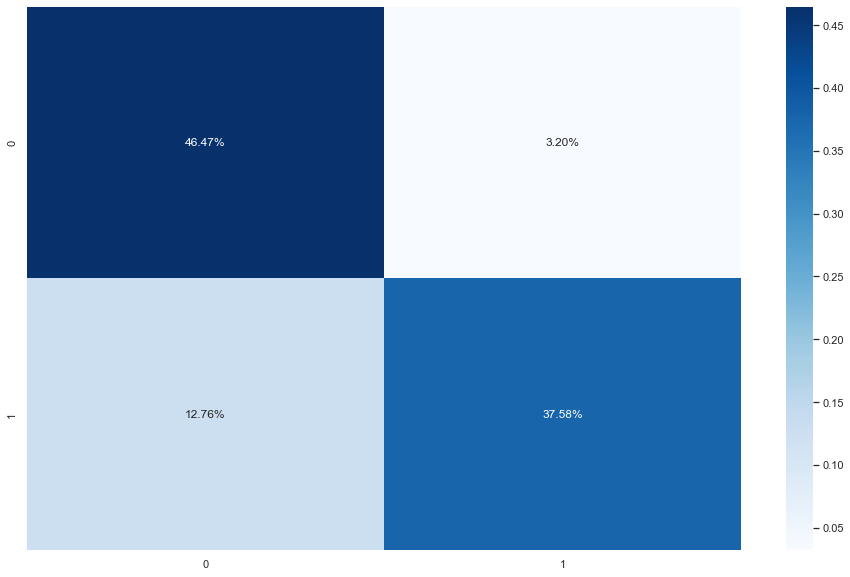

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

predict_x: ndarray = \
    dcnn.predict(X_test)

y_pred: ndarray = \
    (predict_x > 0.5).astype("int32")

matrix: ndarray = \
    confusion_matrix(y_test, y_pred)

print(classification_report(y_pred, y_test))

plt.figure(figsize = (16, 10))
sns.heatmap(matrix / np.sum(matrix), annot = True, fmt = '.2%', cmap = 'Blues')

### Precision

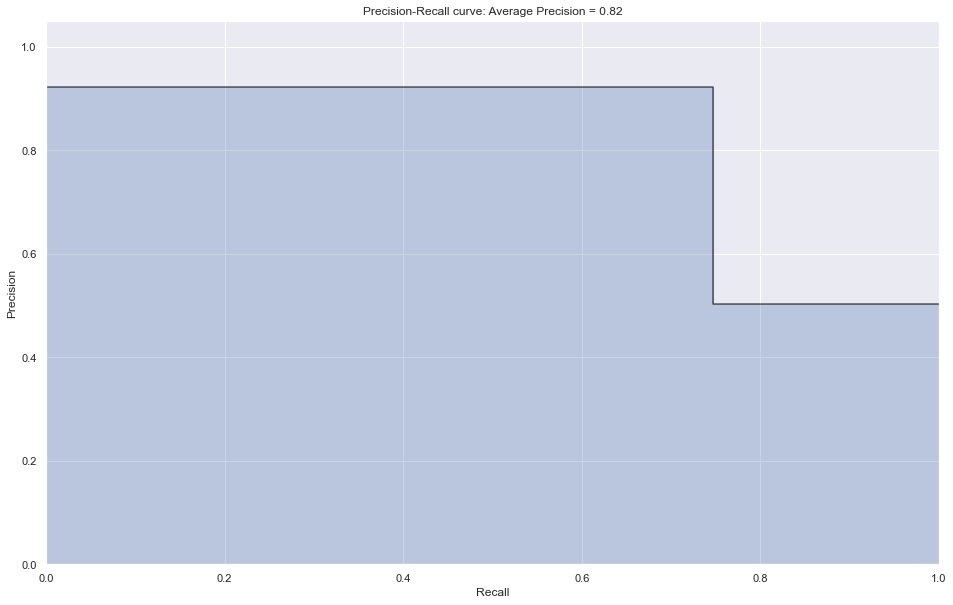

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from numpy import float64

def plot_precision(y_true: ndarray, y_pred: ndarray) -> None:
    precision: ndarray
    recall: ndarray
    precision, recall, _ = \
    precision_recall_curve(y_true, y_pred)
    average_precision: float64 = \
    average_precision_score(y_true, y_pred)
    plt.figure(figsize=(16, 10))
    plt.step(recall, precision, color = 'k', alpha = 0.7, where = 'post')
    plt.fill_between(recall, precision, step = 'post', alpha = 0.3, color = 'b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))
    plt.show()

plot_precision(y_test, y_pred)

### AUC curve

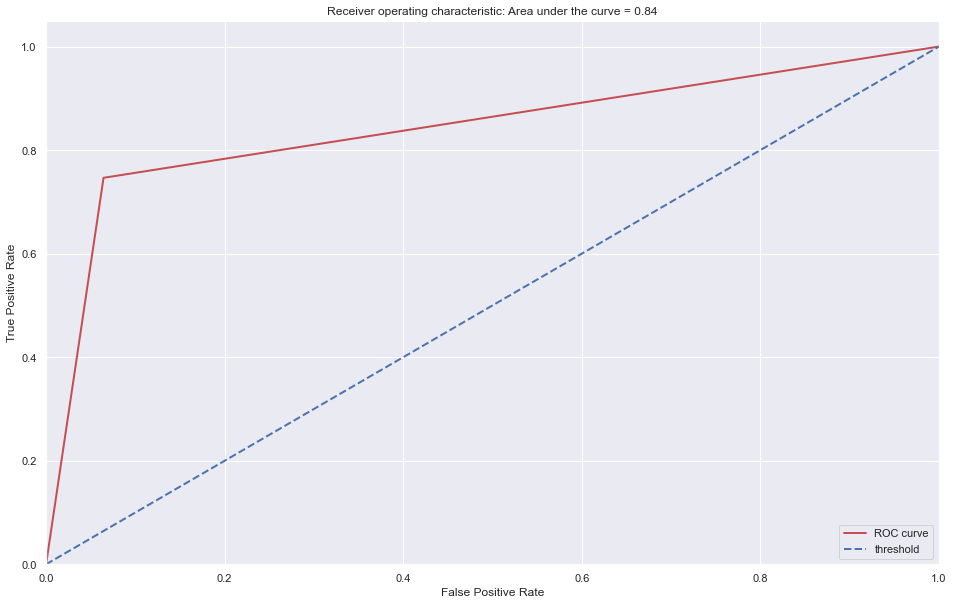

In [41]:
from sklearn.metrics import roc_curve, auc

def plot_auc(y_true: ndarray, y_pred: ndarray) -> None:
    fpr: ndarray
    tpr: ndarray
    fpr, tpr, _ = \
    roc_curve(y_true, y_pred)
    areaUnderROC: float64 = auc(fpr, tpr)
    plt.figure(figsize=(16, 10))
    plt.plot(fpr, tpr, color = 'r', lw = 2, label = 'ROC curve')
    plt.plot([0, 1], [0, 1], color = 'b', lw = 2, linestyle = '--', label = 'threshold')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

plot_auc(y_test, y_pred)

## Search similar sentences

In [42]:
def search_similar_sentences(sentences: Series, search_sentence: str) -> DataFrame:
    similarities: List[Tuple[str, float]] = []

    search_document: Doc = \
        nlp(search_sentence)

    clean_search_document: Doc = \
        nlp(' '.join([str(word) for word in search_document if not word.is_stop and not word.is_punct]))

    for sentence in sentences:
        search_sentence: Doc = \
            nlp(sentence)

        clean_search_sentence: Doc = \
            nlp(' '.join([str(word) for word in search_sentence if not word.is_stop and not word.is_punct]))

        similarities.append((sentence, clean_search_document.similarity(clean_search_sentence)))
    
    search_results: DataFrame = \
        DataFrame(similarities, columns = ['sentence', 'similarity'])

    return search_results.sort_values(by = ['similarity'], ascending = False)

similar_sentences: DataFrame = \
    search_similar_sentences(clean_dataset.Sentence.iloc[1:100], clean_dataset.Sentence.iloc[0])

print(f'\nwyraz do wyszukania: {clean_dataset.Sentence.iloc[0]}')
print(similar_sentences.head(100))


wyraz do wyszukania: Polecam nie pierwszy i nie ostatni raz!
                                             sentence  similarity
59            Wszystko załatwione pomyślnie. Polecam!    0.481337
84  wszystko w jak najlepszym porządku, szybko i p...    0.468931
62  Rewelacja. Wieczorem kupiłem następnego dnia p...    0.449489
82               profesjonalnie i ekspresowo, polecam    0.447162
43  Transakcja przebiegła pomyślnie, wszystko OK. ...    0.435976
..                                                ...         ...
67                    Profesjonalna i szybka  obsługa    0.086469
53             Profesjonalna obsługa, szybka wysyłka.    0.074374
89          WSZYSTKO OK !!!!! POLECAM FACHOWOŚĆ 100 %    0.069319
19              Bardzo szybka wysyłka. Firma na plus.    0.061354
47                    TRANSAKCJA PRZEBIEGŁA POMYŚLNIE   -0.028629

[99 rows x 2 columns]


## Predict results

### Negative sample

In [43]:
text_to_predict: str = \
    'strata czasu.'
    
vector: ndarray = \
    nlp(text_to_predict, disable="ner tagger parser").vector
    
vector_input: ndarray = \
    np.transpose(np.expand_dims(vector, axis = 1))

np.squeeze(dcnn(vector_input.get(), training=False))

array(0.01194425, dtype=float32)

### Positive sample

In [45]:
text_to_predict: str = \
    'gorąco polecam. wszystko poszło sprawnie'
    
vector: ndarray = \
    nlp(text_to_predict, disable="ner tagger parser").vector
    
vector_input: ndarray = \
    np.transpose(np.expand_dims(vector, axis = 1))
    
dcnn(vector_input.get(), training=False).numpy()

array([[0.90256965]], dtype=float32)